In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import os
from datetime import datetime
from io import StringIO

def load_and_normalize_data(e2_path, srs_path, stats=None):
    e2_data = np.load(e2_path)
    srs_data = np.load(srs_path).astype(np.float32)

    if stats is None:
        srs_min = srs_data.min(axis=(0, 1), keepdims=True)
        srs_max = srs_data.max(axis=(0, 1), keepdims=True)
        stats = (srs_min, srs_max)
        print("[INFO] Calculated training SRS normalization stats")
    else:
        srs_min, srs_max = stats
        print("[INFO] Using provided SRS normalization stats")

    srs_norm = (srs_data - srs_min) / (srs_max - srs_min + 1e-7)
    return e2_data, srs_norm, stats

def denormalize_srs(srs_norm, stats):
    srs_min, srs_max = stats
    return srs_norm * (srs_max - srs_min) + srs_min

def get_fast_dataset(e2_data, srs_data, batch_size=4, e2_len=20,
                     srs_input_rows=100, pred_offset=5):

    num_steps_srs = (len(srs_data) - (srs_input_rows + pred_offset)) // 50
    num_steps_e2 = len(e2_data) - e2_len
    num_steps = min(num_steps_e2, num_steps_srs)

    def data_generator():
        for t in range(num_steps):
            # ---- E2 ----
            e2_chunk = e2_data[t:t + e2_len]
            X_e2 = np.zeros(280, dtype=np.float32)
            X_e2[:e2_chunk.size] = e2_chunk.flatten()[:280]
            X_e2 = X_e2.reshape(5, 4, 14)

            # ---- SRS input ----
            srs_start = t * 50
            X_srs = srs_data[srs_start:srs_start + srs_input_rows]
            X_srs = X_srs.reshape(20, 20, 1536)

            # ---- Label ----
            y = srs_data[srs_start + srs_input_rows + pred_offset - 1]

            yield (X_e2, X_srs), y

    output_signature = (
        (
            tf.TensorSpec((5, 4, 14), tf.float32),
            tf.TensorSpec((20, 20, 1536), tf.float32)
        ),
        tf.TensorSpec((4, 1536), tf.float32)
    )

    return (
        tf.data.Dataset.from_generator(data_generator, output_signature=output_signature)
        .cache()
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

def save_model_log(model_summary_str, test_results, log_file="logs/performance_log.txt"):
    os.makedirs(os.path.dirname(log_file), exist_ok=True)

    with open(log_file, "a") as f:
        f.write("\n" + "="*50 + "\n")
        f.write(f"LOG TIME: {datetime.now()}\n")
        f.write("="*50 + "\n\n")
        f.write("===== MODEL SUMMARY =====\n")
        f.write(model_summary_str + "\n")
        f.write("=========================\n\n")
        f.write("===== TEST RESULTS =====\n")
        for k, v in test_results.items():
            f.write(f"{k}: {v}\n")
        f.write("=========================\n\n")

    print(f"Appended log to {log_file}")
    return log_file

e2_train, srs_train, train_stats = load_and_normalize_data("E2_train.npy", "SRS_train.npy")
train_ds = get_fast_dataset(e2_train, srs_train, batch_size=8) 

test_e2_npy = "P:/SP Challenge/Model/E2_test.npy"
test_srs_npy = "P:/SP Challenge/Model/SRS_test.npy"

test_e2, test_srs, test_stats = load_and_normalize_data(
    test_e2_npy,
    test_srs_npy
)
test_ds = get_fast_dataset(
    test_e2,
    test_srs,
    batch_size=4
)

[INFO] Calculated training SRS normalization stats
[INFO] Calculated training SRS normalization stats


In [12]:
def create_model(e2_input_shape=(5, 4, 14), srs_input_shape=(20, 20, 1536), 
                 lstm_units=128, dropout_rate=0.2, stats=None):

    # --- Radio Branch ---
    radio_input = layers.Input(shape=e2_input_shape, name='radio_input')
    r1 = layers.Normalization()(radio_input)
    r1 = layers.Conv2D(32, (3, 3), padding='same')(r1)
    r1 = layers.BatchNormalization()(r1)
    r1 = layers.Activation('relu')(r1)
    r1 = layers.ZeroPadding2D(padding=((0,0),(0,1)))(r1) 
    r1 = layers.Conv2D(64, (3, 3), padding='same')(r1)
    r1 = layers.BatchNormalization()(r1)
    r1 = layers.Activation('relu')(r1)
    r1 = layers.Conv2D(128, (2, 2), padding='same')(r1)
    r1 = layers.BatchNormalization()(r1)
    r1 = layers.Activation('relu')(r1)

    # --- SRS Branch ---
    srs_input = layers.Input(shape=srs_input_shape, name='srs_input')
    s1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(srs_input)
    
    # Residual Block 1
    s1_res1 = layers.Conv2D(256, (1, 1), padding='valid')(s1)
    s1_res1 = layers.BatchNormalization()(s1_res1)
    s1_res1 = layers.Activation('relu')(s1_res1)
    s1_res1 = layers.Conv2D(256, (3, 3), padding='same')(s1_res1)
    s1_res1 = layers.BatchNormalization()(s1_res1)
    s1_res1 = layers.Activation('relu')(s1_res1)
    s1_res1 = layers.Conv2D(512, (1, 1), padding='valid')(s1_res1)
    s1_res1 = layers.BatchNormalization()(s1_res1)
    
    shortcut1 = layers.Conv2D(512, (1, 1), padding='valid')(s1)
    shortcut1 = layers.BatchNormalization()(shortcut1)
    
    s1 = layers.Add()([s1_res1, shortcut1])
    s1 = layers.Activation('relu')(s1)

    # Residual Block 2
    s1_res2 = layers.Conv2D(256, (1, 1), padding='valid')(s1)
    s1_res2 = layers.BatchNormalization()(s1_res2)
    s1_res2 = layers.Activation('relu')(s1_res2)
    s1_res2 = layers.Conv2D(256, (3, 3), padding='same')(s1_res2)
    s1_res2 = layers.BatchNormalization()(s1_res2)
    s1_res2 = layers.Activation('relu')(s1_res2)
    s1_res2 = layers.Conv2D(512, (1, 1), padding='valid')(s1_res2)
    s1_res2 = layers.BatchNormalization()(s1_res2)
    
    shortcut2 = layers.Conv2D(512, (1, 1), padding='valid')(s1)
    shortcut2 = layers.BatchNormalization()(shortcut2)
    
    s1 = layers.Add()([s1_res2, shortcut2])
    s1 = layers.Activation('relu')(s1)

    s1 = layers.AveragePooling2D((2, 2))(s1)
    s1 = layers.AveragePooling2D((2, 2))(s1)

    # --- Fusion & Output ---
    x = layers.Concatenate(axis=-1)([r1, s1]) 
    x = layers.Conv2D(1024, (1, 1), activation='relu', padding='same')(x)
    x = layers.Reshape((25, 1024))(x)
    x = layers.LSTM(lstm_units, return_sequences=True)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(2048, activation='relu')(x)
    
    # This is the normalized prediction
    x = layers.Dense(4 * 1536, activation='linear')(x)
    x = layers.Reshape((4, 1536))(x)

    # --- Denormalization Layer ---
    if stats is not None:
        srs_min, srs_max = stats
        # Converting stats to constants within the graph
        srs_min = tf.constant(srs_min, dtype=tf.float32)
        srs_max = tf.constant(srs_max, dtype=tf.float32)
        
        # Denormalization: (x * (max - min)) + min
        output = layers.Lambda(lambda val: val * (srs_max - srs_min) + srs_min, name="denorm_output")(x)
    else:
        output = layers.Activation('linear', name="output")(x)

    model = models.Model(inputs=[radio_input, srs_input], outputs=output)
    model.compile(optimizer='adam', loss='log_cosh', metrics=['mse'])
    return model




model = create_model(stats=train_stats)
# model.summary()

Epoch 1/100
47/47 [==============================] - 7s 101ms/step - loss: 145.3915 - mse: 87502.5312
Epoch 2/100
47/47 [==============================] - 5s 99ms/step - loss: 43.9929 - mse: 3110.6287
Epoch 3/100
47/47 [==============================] - 5s 100ms/step - loss: 34.8721 - mse: 1951.4592
Epoch 4/100
47/47 [==============================] - 5s 99ms/step - loss: 35.8715 - mse: 2103.9597
Epoch 5/100
47/47 [==============================] - 5s 99ms/step - loss: 35.5991 - mse: 2042.0941
Epoch 6/100
47/47 [==============================] - 5s 99ms/step - loss: 28.9674 - mse: 1389.5720
Epoch 7/100
47/47 [==============================] - 5s 99ms/step - loss: 26.9064 - mse: 1208.9578
Epoch 8/100
47/47 [==============================] - 5s 100ms/step - loss: 27.4470 - mse: 1240.0436
Epoch 9/100
47/47 [==============================] - 5s 100ms/step - loss: 26.0550 - mse: 1146.2545
Epoch 10/100
47/47 [==============================] - 5s 97ms/step - loss: 27.0715 - mse: 1180.5818
Epo

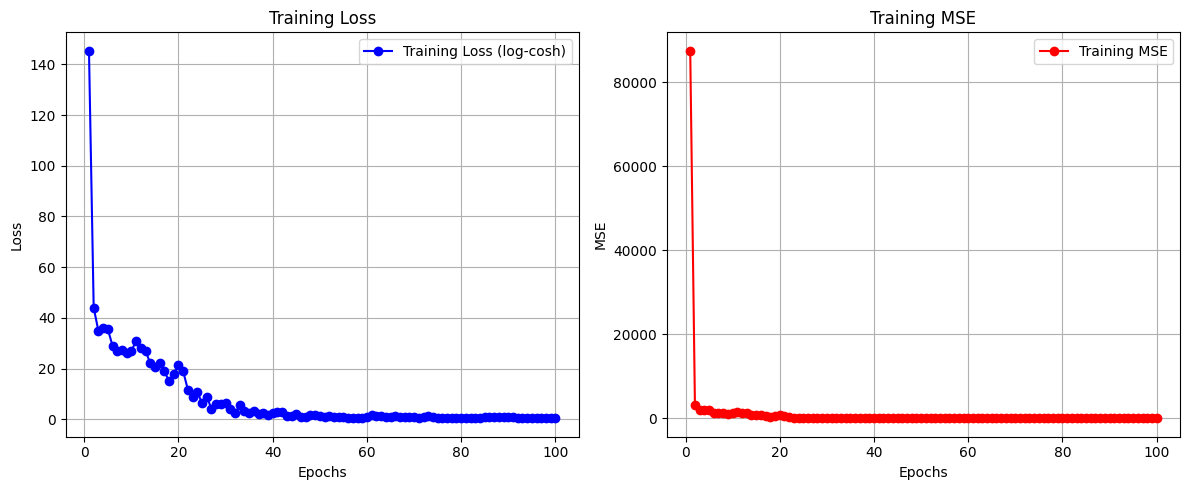

13/13 [==============================] - 1s 33ms/step - loss: 0.5042 - mse: 1.3017
Test Loss: 0.5041618347167969
Test MSE : 1.301662802696228


In [13]:
history = model.fit(train_ds, epochs=100)

loss = history.history['loss']
epochs = range(1, len(loss) + 1)


plt.figure(figsize=(12, 5))

# ---- Loss (log-cosh) ----
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss (log-cosh)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

# ---- MSE ----
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['mse'], 'ro-', label='Training MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training MSE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
results = model.evaluate(test_ds, return_dict=True)

print("Test Loss:", results['loss'])
print("Test MSE :", results['mse'])


In [ ]:
stream = StringIO()
model.summary(print_fn=lambda x: stream.write(x + "\n"))
model_summary_str = stream.getvalue()

# Add model name to the log
model_name = "Current Model"
log_file = save_model_log(f"Model Name: {model_name}\n" + model_summary_str, results)

print(f"Model name '{model_name}' and summary saved to log: {log_file}")

Appended log to logs/performance_log.txt


'logs/performance_log.txt'